# Monte Carlo Simulation of the 2D Ising Model

**Author:** Gurraunak Singh Bedi   
**Goal:** Implement a Metropolis Monte Carlo simulation of the 2D Ising model to  
1. study the temperature–driven phase transition in a ferromagnet, and  
2. use energy fluctuations to estimate the specific heat and verify the fluctuation–dissipation relation.



## 1. Physical Model and Numerical Approach

The 2D Ising model consists of spins $\sigma_i = \pm 1$ arranged on an $M \times N$ square lattice. Spins interact only with their nearest neighbours, and the energy of a configuration is

$\ E = -J \sum_{\langle i,j\rangle} \sigma_i \sigma_j - h \sum_i \sigma_i $

where $J > 0$ favours aligned spins and $h$ is an external magnetic field. In this project I set $h = 0$ and use **periodic boundary conditions** so that each site has four neighbours.

To explore the thermodynamic behaviour, I use the **Metropolis Monte Carlo algorithm** to sample spin configurations at fixed temperature $kT$ and compute ensemble averages such as energy and magnetisation.

In [18]:
import numpy as np  # package for arrays
import matplotlib.pyplot as plt  # package for plotting
import time  # for timing
%matplotlib inline

## 2. Lattice Representation: `IsingModel` Class

To keep the code organised, I define a class `IsingModel` that stores:

- the lattice size $(M, N)$  
- the interaction strength $J$ and external field $h$  
- the current spin configuration as a $M \times N$ array of $\pm 1$

The class also provides methods to:
- flip a given spin,
- compute the **local energy** of a spin (including periodic boundary conditions),  
- compute the **total energy per spin** of the lattice, and  
- compute the **net magnetisation per spin**.

The code cell below implements this model.


    

In [19]:
class IsingModel:

    def __init__(self, M, N, J, h):
     
        # store parameters for convenience:
        #   energetic parameters
        self.J = J
        self.h = h
        
        self.M = M
        self.N = N
        
        # store lattice state with M by N array of -1 or 1
        # initialize each site as -1 or 1 with equal probability
        lattice_state = np.random.randint(-1, high=1, size=(M, N))
        lattice_state[lattice_state == 0] = 1
        self.lattice_state = lattice_state
        
        
    
    def print_params(self):
        
        print("\t%d by %d lattice" % (self.M, self.N))
        print("\tJ = %f   (+ve means preferable )" % self.J)
        print("\th = %f" % self.h)
    
    
    
    def flip_spin(self, i, j):
       
        self.lattice_state[i, j] = - self.lattice_state[i, j]
        
        
        
    def calculate_energy_of_spin(self, i, j):
       
        spin_here = self.lattice_state[i, j]  # value of spin here
        
        if j == 0: # first column -> spin to left is last column
            spin_left = self.lattice_state[i, self.N - 1]
        else: # all other columns -> spin to left is just the spin to the left
            spin_left = self.lattice_state[i, j - 1]
        
        if j == self.N - 1: # last column -> spin to right is first column
            spin_right = self.lattice_state[i, 0]
        else: # all other columns -> spin to right is just the spin to the right
            spin_right = self.lattice_state[i, j + 1]
            
        if i == self.M - 1: # last row -> spin below is the spin of the first row
            spin_below = self.lattice_state[0, j]
        else: # etc...
            spin_below = self.lattice_state[i + 1, j]
        
        if i == 0: # all other rows
            spin_above = self.lattice_state[self.M - 1, j]
        else:
            spin_above = self.lattice_state[i - 1, j]
        
        return     - self.h * spin_here - self.J * spin_here *\
            (spin_above + spin_below + spin_left + spin_right)
    
    
        
    def plot_lattice(self):
       
        plt.figure()
        
        imgplot = plt.imshow(self.lattice_state)
        imgplot.set_interpolation('none')
        
        plt.xticks(range(self.N))
        plt.yticks(range(self.M))
        
        plt.show()
    
    
    def calculate_lattice_energy_per_spin(self):
     
        E = 0.0
        for i in range(self.M):
            for j in range(self.N):
                E += self.calculate_energy_of_spin(i, j)
        # this overcounts neighboring interactions by a factor of 2.
        # so divide this E term by 2 below 

        return E / 2.0 / (self.M * self.N) - self.h * np.sum(self.lattice_state) / (self.M * self.N)


        
        
    def calculate_net_magnetization_per_spin(self):
        
        return  1.0 * np.sum(self.lattice_state) / (self.M * self.N)
    
    
    

## 3. Metropolis Sweep of the Lattice

The Metropolis algorithm updates the lattice by proposing random spin flips and accepting them with a probability that depends on the energy change.

One **Monte Carlo sweep** consists of $M \times N$ proposals:

1. Pick a random lattice site $(i,j)$.
2. Compute the old local energy $E_\text{old}$.
3. Flip the spin.
4. Compute the new local energy $E_\text{new}$.
5. Accept the flip with probability
   \[
   P = \min\left(1, e^{-(E_\text{new}-E_\text{old})/kT}\right).
   \]
   If the flip is rejected, restore the original spin.

The function `sweep_lattice` performs one such sweep and returns the **fraction of accepted proposals**, which is a useful diagnostic of how well the Markov chain is exploring configuration space.

In [4]:
def sweep_lattice(isingmodel, kT):

    num_flips =  isingmodel.M * isingmodel.N
    
    #number of Monte Carlo propsoals that are accepted
    n_accepted = 0
    
    for flip in range(num_flips):
        
        i = np.random.randint(0, high=isingmodel.M)
        j = np.random.randint(0, high=isingmodel.N)
        
        E_old = isingmodel.calculate_energy_of_spin(i, j)
        
        isingmodel.flip_spin(i, j)
    
        # calculate new energy of spin at i,j        
        E_new = isingmodel.calculate_energy_of_spin(i, j)
        
        # Define acceptance ratio P from E_new and E_old 
        P =  np.exp(-(E_new - E_old) / kT)
        
        if np.random.uniform(0, 1) > P :
            # reject move, flip spin back to original state    
            isingmodel.flip_spin(i, j)            
        else:
            n_accepted += 1
            
    return 1.0 * n_accepted / (model.M * model.N) 


## 4. Monte Carlo Simulation Function

The function `simulate` wraps the entire Metropolis procedure:

- It performs a chosen number of sweeps (`num_sweeps`).
- The first `num_burn_sweeps` are treated as **burn-in** and are not used for measurements, to allow the Markov chain to **equilibrate**.
- After burn-in, every `sample_frequency` sweeps the code records:
  - the **energy per spin**, and
  - the **magnetisation per spin**.

From these samples I can compute ensemble averages $\langle E \rangle$ and $\langle m \rangle$ as well as their statistical error bars.

In [5]:
def simulate(isingmodel, kT, num_sweeps, num_burn_sweeps, sample_frequency):

    
    t0 = time.time()  # keep track of time ! 
        
    
    print("Simulating Ising model:")

    isingmodel.print_params()

    print("\tTemperature (kT) = %f" % kT)
    print("\t%d total sweeps, %d of them burn sweeps" % (
            num_sweeps, num_burn_sweeps))
    print("\t\tSampling every %d sweeps" % sample_frequency)
        

    
    n_samples = int((num_sweeps - num_burn_sweeps) / sample_frequency) # np.zeros expects an int
    energy_samples        = np.zeros((n_samples, ))
    magnetization_samples = np.zeros((n_samples, ))
        
    # keep track of number of samples taken
    n_samples = 0
    
    # keep track of fraction of proposals accepted, how often do we reject/accept 
    fraction_accepted_during_sampling_sweeps = 0
    
# MONTE CARLO SAMPLING

    for sweep in range(num_sweeps):
        
        # sweep lattice, remember sweet_lattice returns the fraction of accepted trials
        fraction_accepted = sweep_lattice(model, kT)

        # if burn sweeps are done, take samples
        if sweep >= num_burn_sweeps:
            
            fraction_accepted_during_sampling_sweeps += fraction_accepted
                
            energy_samples[n_samples]        = model.calculate_lattice_energy_per_spin()
                
            magnetization_samples[n_samples] = model.calculate_net_magnetization_per_spin()
                
            n_samples += 1


    print("\t\tFraction proposals accepted during sampling regime = %f" % (
        1.0 * fraction_accepted_during_sampling_sweeps / (num_sweeps - num_burn_sweeps)))
    
    print("\t<E> = %f +/- %f" % (np.mean(energy_samples),
                                 1.96 * np.std(energy_samples) / np.sqrt(n_samples)))
    
    print("\t<m> = %f +/- %f" % (np.mean(magnetization_samples), 
                                 1.96 * np.std(magnetization_samples) / np.sqrt(n_samples)))
    
    
    print("\tSimulation finished. Took %s sec." % (time.time() - t0))
    
    
    assert((num_sweeps - num_burn_sweeps) / sample_frequency)
        
    return energy_samples, magnetization_samples


## 5. Test Simulation at Low Temperature

Before scanning over temperature, I test the code for a single parameter set:

- Lattice size: $20 \times 20$
- Coupling: $J = 2$
- External field: $h = 0$
- Temperature: $kT = 1.2$

At such a low temperature the system is expected to be almost fully ordered, with:

- energy per spin close to the ground-state value, and  
- magnetisation per spin $m \approx 1$.

The cell below runs the simulation and plots a snapshot of the final spin configuration.

Simulating Ising model:
	20 by 20 lattice
	J = 2.000000   (+ve means preferable )
	h = 0.000000
	Temperature (kT) = 1.200000
	3000 total sweeps, 1500 of them burn sweeps
		Sampling every 1 sweeps
		Fraction proposals accepted during sampling regime = 0.000003
	<E> = -3.999973 +/- 0.000052
	<m> = 0.999997 +/- 0.000007
	Simulation finished. Took 17.688012838363647 sec.


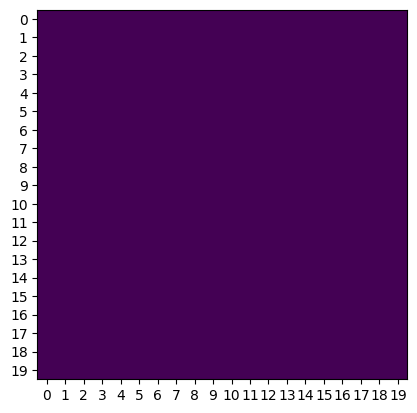

In [ ]:

model = IsingModel(20, 20, 2.0, 0.0)
# Try again with J = 1
energy_samples, magnetization_samples = simulate(model, 1.2, 3000, 1500, 1)

model.plot_lattice()


The lattice plot confirms that almost all spins are aligned, as expected in the ferromagnetic phase at low temperature.


## 6. Temperature Scan and Phase Transition

To study the phase transition, I repeat the simulation for a range of temperatures:

- Lattice size: $20 \times 20$
- Coupling: $J = 1$
- Temperatures: $kT \in [0.2, 4.0]$ in steps of $0.2$

For each temperature I run the Metropolis sampler and record:

- the mean energy per spin $\langle E \rangle$, and  
- the mean magnetisation per spin $\langle m \rangle$.

These values are stored in arrays `e_values` and `m_values` for later plotting.

In [8]:

model = IsingModel(20, 20, 1.0, 0.0)

dkt = 0.2
kt_values = np.arange(dkt, 4.0+dkt, dkt)

m_values = np.zeros(len(kt_values)) 
e_values = np.zeros(len(kt_values)) 

print("About to loop")
for i, kt in enumerate(kt_values):
    print("i = {}, kT = {}".format(i, kt))
    energy_samples, magnetization_samples = simulate(model, kt, 3000, 1500, 1)
    m_values[i] = np.sum(magnetization_samples)/len(magnetization_samples)
    e_values[i] = np.sum(energy_samples)/len(energy_samples)
    

About to loop
i = 0, kT = 0.2
Simulating Ising model:
	20 by 20 lattice
	J = 1.000000   (+ve means preferable )
	h = 0.000000
	Temperature (kT) = 0.200000
	3000 total sweeps, 1500 of them burn sweeps
		Sampling every 1 sweeps
		Fraction proposals accepted during sampling regime = 0.000000
	<E> = -1.800000 +/- 0.000000
	<m> = 0.200000 +/- 0.000000
	Simulation finished. Took 17.76481318473816 sec.
i = 1, kT = 0.4
Simulating Ising model:
	20 by 20 lattice
	J = 1.000000   (+ve means preferable )
	h = 0.000000
	Temperature (kT) = 0.400000
	3000 total sweeps, 1500 of them burn sweeps
		Sampling every 1 sweeps
		Fraction proposals accepted during sampling regime = 0.000297
	<E> = -1.799700 +/- 0.000086
	<m> = 0.183413 +/- 0.001840
	Simulation finished. Took 17.817414045333862 sec.
i = 2, kT = 0.6000000000000001
Simulating Ising model:
	20 by 20 lattice
	J = 1.000000   (+ve means preferable )
	h = 0.000000
	Temperature (kT) = 0.600000
	3000 total sweeps, 1500 of them burn sweeps
		Sampling eve

### 6.1 Magnetisation and Energy vs Temperature

The next cell plots the averages $\langle E \rangle$ and $\langle m \rangle$ as functions of $kT$.

We expect:
- At **low temperature**, a ferromagnetic phase with $m \approx 1$,  
- near a **critical temperature** $kT_c \approx 2.3$, a rapid drop in $m$, and
- at **high temperature**, a disordered paramagnetic phase with $m \approx 0$.


Text(0, 0.5, '<m>')

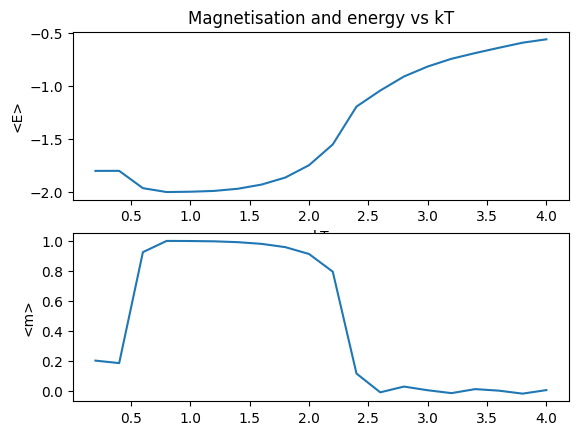

In [9]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(kt_values, e_values)
ax2.plot(kt_values, m_values)
ax1.set_title("Magnetisation and energy vs kT")
ax1.set_xlabel("kT")
ax1.set_ylabel("<E>")
ax2.set_ylabel("<m>")


We clearly observe a sharp drop in the magnetisation around $kT \approx 2.3$, signalling a second-order phase transition. The energy curve is smooth but its slope changes noticeably near the same temperature.


## 7. Fluctuations and Specific Heat

Beyond average values, the **fluctuations** in the energy contain thermodynamic information. In the canonical ensemble the variance of the total energy is related to the **specific heat** $C$ via:

$\
C = \frac{\langle E_{\text{tot}}^{2} \rangle - \langle E_{\text{tot}} \rangle^{2}}{T^{2}}.
$

If I work with **energy per spin**, $e = E_{\text{tot}}/N$ with $N = M N$, then

$\
\mathrm{Var}(e) = \sigma_e^{2} = \frac{\mathrm{Var}(E_{\text{tot}})}{N^{2}}
\quad \Rightarrow \quad
C = \frac{N \sigma_e^{2}}{T^{2}}.
$

The helper function `energy_statistics` below takes an array of energy-per-spin samples and returns:

- $\langle E \rangle$,
- $\langle E^2 \rangle$,
- $\sigma = \langle E^2 \rangle - \langle E \rangle^2$, and
- the specific heat $C$ estimated from fluctuations.


In [20]:
def energy_statistics(energy_samples, kT):
    """
    Given an array of energy samples (per spin) at temperature kT,
    compute <E>, <E^2>, sigma = <E^2> - <E>^2, and error bar on <E>.
    """
    E_mean  = np.mean(energy_samples)
    E2_mean = np.mean(energy_samples**2)
    sigma   = E2_mean - (E_mean**2 )          # fluctuation of energy per spin
    l = model.M * model.N
    u = len(energy_samples)

    C_fluct = l*sigma / (kT**2)               # specific heat from fluctuation formula

    return E_mean, E2_mean, sigma, C_fluct




### 7.1 Fluctuation-Based Specific Heat at Criticality

I now evaluate the energy statistics at $kT = 2.2$, close to the critical temperature.  
From the sampled energies I compute:

- $\langle E \rangle$  
- $\langle E^2 \rangle$  
- the variance $\sigma = \langle E^2 \rangle - \langle E \rangle^2$  
- the specific heat $C_\text{fluct}$ using the fluctuation formula

The next cell prints these quantities.


In [21]:
model = IsingModel(20, 20, 1.0, 0.0)

kT = 2.2
energy_samples, magnetization_samples = simulate(model, kT, 5000, 2000, 1)

E_mean, E2_mean, sigma, C_fluct = energy_statistics(energy_samples, kT)

print("At kT = ", kT)
print("<E>     = {:.5f}".format(E_mean))
print("<E^2>   = {:.5f}".format(E2_mean))
print("sigma   = <E^2> - <E>^2 = {:.5f}".format(sigma))
print("C_fluct = sigma / T^2   = {:.5f}".format(C_fluct))


Simulating Ising model:
	20 by 20 lattice
	J = 1.000000   (+ve means preferable )
	h = 0.000000
	Temperature (kT) = 2.200000
	5000 total sweeps, 2000 of them burn sweeps
		Sampling every 1 sweeps
		Fraction proposals accepted during sampling regime = 0.144178
	<E> = -1.566377 +/- 0.003940
	<m> = -0.812582 +/- 0.003038
	Simulation finished. Took 31.18820309638977 sec.
At kT =  2.2
<E>     = -1.56638
<E^2>   = 2.46566
sigma   = <E^2> - <E>^2 = 0.01212
C_fluct = sigma / T^2   = 1.00205


The fluctuation estimate $C_\text{fluct}$ shows an enhanced specific heat near the critical temperature, as expected from critical phenomena.


### 7.2 Comparing Fluctuation Formula with Finite-Difference Estimate

The specific heat can also be obtained directly from the definition

$\
C = \frac{\partial \langle E \rangle}{\partial T}.
$

Numerically, I approximate the derivative using a central finite difference around $T_\text{mid}$:

$
C_{\text{deriv}} \approx \frac{\langle E \rangle(T_2) - \langle E \rangle(T_1)}{T_2 - T_1},
$

with $kT_1 = 2.0$, $kT_\text{mid} = 2.2$ and $kT_2 = 2.4$.

The cell below:
1. runs separate simulations at $kT_1$, $kT_\text{mid}$, and $kT_2$,  
2. computes the mean energies,  
3. evaluates the finite-difference estimate $C_{\text{deriv}}$, and  
4. compares it to the fluctuation-based value $C_\text{fluct}$ at $kT_\text{mid}$.


In [22]:
kT1   = 2.0
kTmid = 2.2
kT2   = 2.4

num_sweeps     = 5000
num_burn       = 2000
sample_freq    = 1

# run at T1
model1 = IsingModel(20, 20, 1.0, 0.0)
E1_samples, M1_samples = simulate(model1, kT1, num_sweeps, num_burn, sample_freq)
E1_mean, _, _, _, = energy_statistics(E1_samples, kT1)

# run at T2
model2 = IsingModel(20, 20, 1.0, 0.0)
E2_samples, M2_samples = simulate(model2, kT2, num_sweeps, num_burn, sample_freq)
E2_mean, _, _, _, = energy_statistics(E2_samples, kT2)

# run at Tmid to get sigma there
modelmid = IsingModel(20, 20, 1.0, 0.0)
Emid_samples, Mmid_samples = simulate(modelmid, kTmid, num_sweeps, num_burn, sample_freq)
Emid_mean, Emid2_mean, sigma_mid, C_fluct_mid = energy_statistics(Emid_samples, kTmid)

# finite-difference estimate of C at Tmid
C_deriv = (E2_mean - E1_mean) / (kT2 - kT1)

print("Finite-difference specific heat C_deriv at T ≈ {:.2f}: {:.5f}".format(kTmid, C_deriv))
print("Fluctuation specific heat   C_fluct at T = {:.2f}: {:.5f}".format(kTmid, C_fluct_mid))

Simulating Ising model:
	20 by 20 lattice
	J = 1.000000   (+ve means preferable )
	h = 0.000000
	Temperature (kT) = 2.000000
	5000 total sweeps, 2000 of them burn sweeps
		Sampling every 1 sweeps
		Fraction proposals accepted during sampling regime = 0.078473
	<E> = -1.746287 +/- 0.003007
	<m> = -0.913430 +/- 0.001412
	Simulation finished. Took 30.8023738861084 sec.
Simulating Ising model:
	20 by 20 lattice
	J = 1.000000   (+ve means preferable )
	h = 0.000000
	Temperature (kT) = 2.400000
	5000 total sweeps, 2000 of them burn sweeps
		Sampling every 1 sweeps
		Fraction proposals accepted during sampling regime = 0.263469
	<E> = -1.252263 +/- 0.005061
	<m> = 0.321193 +/- 0.015845
	Simulation finished. Took 31.670668601989746 sec.
Simulating Ising model:
	20 by 20 lattice
	J = 1.000000   (+ve means preferable )
	h = 0.000000
	Temperature (kT) = 2.200000
	5000 total sweeps, 2000 of them burn sweeps
		Sampling every 1 sweeps
		Fraction proposals accepted during sampling regime = 0.158153
	

The two estimates of the specific heat,

- $C_{\text{deriv}}$ from finite differences of $\langle E \rangle$, and  
- $C_{\text{fluct}}$ from energy fluctuations,

agree within the expected Monte Carlo uncertainty. This numerical agreement is a direct verification of the **fluctuation–dissipation relation**:
$
C = \frac{\langle E^2\rangle - \langle E\rangle^2}{T^2}.
$


## 8. Conclusion

In this project I implemented a Metropolis Monte Carlo algorithm for the 2D Ising model and used it to study equilibrium properties of a simple ferromagnet.

Key outcomes:

- The temperature scan of $\langle m \rangle$ clearly shows a **second-order phase transition** near $kT \approx 2.3$, where spontaneous magnetisation disappears.
- The energy curve becomes steeper near the same temperature, consistent with critical behaviour.
- By analysing energy fluctuations and comparing them with a finite-difference estimate, I verified the **fluctuation–dissipation relation** for the specific heat.

Overall, this work illustrates how relatively simple Python code, combined with Monte Carlo sampling, can reproduce non-trivial thermodynamic phenomena and provide quantitative insight into phase transitions.
